# **PROJET ITK-VTK**

## Auteurs
### Majeure IMAGE

- David CHEMALY
    - login: david.chemaly
<br /> <br />
- Thuraya SHANBARI
    - login: thuraya.shanbari

# Partie 1
---

## Import des librairies

In [1]:
import itk
itk.Version.GetITKVersion()

'5.3.0'

In [2]:
import vtk
vtk.vtkVersion.GetVTKVersion()

'9.2.6'

In [3]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.__version__

'3.7.1'

## Paramètres

Tout d'abord, nous allons définir les paramètres de notre programme. Nous allons utiliser les paramètres suivants:

In [4]:
fixed_image_path = 'Data/case6_gre1.nrrd'
moving_image_path = 'Data/case6_gre2.nrrd'

Nous définir la dimension de l'image, le type de pixel et le type de pixel de sortie

In [5]:
Dimension = 3

PixelType = itk.ctype('float')
ImageType = itk.Image[PixelType, Dimension]

FixedImageType = ImageType
MovingImageType = ImageType

## Chargement des données

L'implémentation de la fonction de chargement des données est la suivante:

In [6]:
def read_file(file_path):
    readerType = itk.ImageFileReader[ImageType]
    reader = readerType.New()
    reader.SetFileName(file_path)
    reader.Update()
    image = reader.GetOutput()
    return image

Ensuite, nous allons charger les données en utilisant la fonction précédente, et nous allons afficher la taille des images chargées.

In [7]:
fixed_image = read_file(fixed_image_path)
moving_image = read_file(moving_image_path)

print("Fixed image size: " + str(fixed_image.GetLargestPossibleRegion().GetSize()))
print("Moving image size: " + str(moving_image.GetLargestPossibleRegion().GetSize()))

Fixed image size: itkSize3 ([256, 256, 176])
Moving image size: itkSize3 ([256, 256, 176])


## Affichage des données

Nous allons afficher deux images côte à côte, l'image fixe et l'image mobile pour pouvoir les comparer. Pour cela nous allons utiliser la fonction suivante:

In [8]:
def display_images(image1, image2, slice_number):
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(image1[slice_number, :, :], cmap='gray')
    plt.title(f"Slice {slice_number}")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(image2[slice_number, :, :], cmap='gray')
    plt.title(f"Slice {slice_number}")
    plt.axis('off')
    plt.show()

Voici un exemple d'affichage des images:

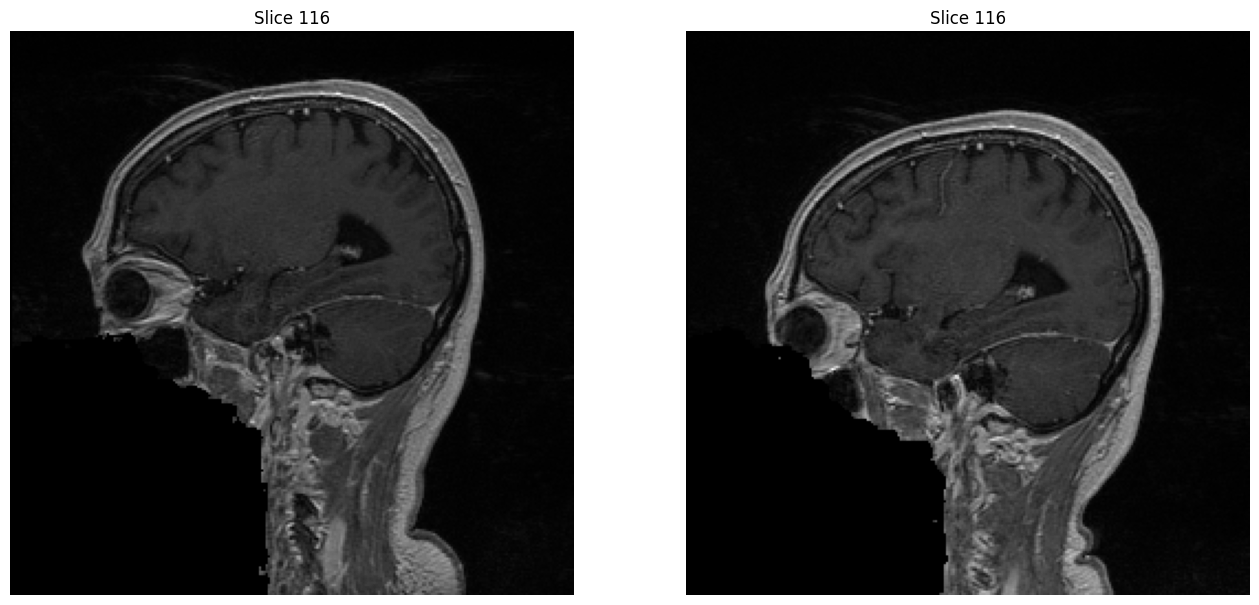

In [9]:
display_images(fixed_image, moving_image, 116)

## Pipeline

Cette fonction resample_image prend trois paramètres en entrée : `fixed_image`, `moving_image`, et `transform`. Elle effectue une opération de rééchantillonnage sur l'image moving_image en utilisant un filtre de rééchantillonnage `itk.ResampleImageFilter`.

In [10]:
def resample_image(fixed_image, moving_image, transform):
    resampleFilterType = itk.ResampleImageFilter[MovingImageType, FixedImageType]
    resampleFilter = resampleFilterType.New()
    resampleFilter.SetInput(moving_image)
    resampleFilter.SetTransform(transform)
    resampleFilter.SetSize(fixed_image.GetLargestPossibleRegion().GetSize())
    resampleFilter.SetOutputOrigin(fixed_image.GetOrigin())
    resampleFilter.SetOutputSpacing(fixed_image.GetSpacing())
    resampleFilter.SetOutputDirection(fixed_image.GetDirection())
    resampleFilter.SetDefaultPixelValue(100)
    resampleFilter.Update()
    return resampleFilter.GetOutput()

### 1. Recalage rigide

La fonction `register_images_rigid3D` effectue l'enregistrement de deux images tridimensionnelles, `fixed_image` et `moving_image`, en utilisant une transformation rigide versor en 3D. Voici comment la fonction est implémentée: 

In [11]:
def register_images_rigid3D(fixed_image, moving_image):
    
    TransformType = itk.VersorRigid3DTransform[itk.D]
    OptimizerType = itk.RegularStepGradientDescentOptimizerv4[itk.D]
    MetricType = itk.MeanSquaresImageToImageMetricv4[FixedImageType, MovingImageType]
    RegistrationType = itk.ImageRegistrationMethodv4[FixedImageType, MovingImageType]

    metric = MetricType.New()
    optimizer = OptimizerType.New()
    registration = RegistrationType.New()

    registration.SetMetric(metric)
    registration.SetOptimizer(optimizer)

    registration.SetFixedImage(fixed_image)
    registration.SetMovingImage(moving_image)

    initial_transform = TransformType.New()

    TransformInitializerType = itk.CenteredTransformInitializer[TransformType, FixedImageType, MovingImageType]
    initializer = TransformInitializerType.New()

    initializer.SetTransform(initial_transform)
    initializer.SetFixedImage(fixed_image)
    initializer.SetMovingImage(moving_image)
    initializer.MomentsOn()
    initializer.InitializeTransform()

    VersorType = itk.Versor[itk.D]
    VectorType = itk.Vector[itk.D, Dimension]

    rotation = VersorType()

    axis = VectorType()
    axis[0] = 0.0
    axis[1] = 0.0
    axis[2] = 1.0

    angle = 0.0

    rotation.Set(axis, angle)

    initial_transform.SetRotation(rotation)

    registration.SetInitialTransform(initial_transform)

    OptimizerScalesType = itk.OptimizerParameters[itk.D]
    optimizer_scales = OptimizerScalesType(initial_transform.GetNumberOfParameters())

    translation_scale = 1.0 / 1000.0

    optimizer_scales[0] = 1.0
    optimizer_scales[1] = 1.0
    optimizer_scales[2] = 1.0

    optimizer_scales[3] = translation_scale
    optimizer_scales[4] = translation_scale
    optimizer_scales[5] = translation_scale

    optimizer.SetScales(optimizer_scales)
    optimizer.SetNumberOfIterations(200)
    optimizer.SetLearningRate(0.1)
    optimizer.SetMinimumStepLength(0.001)
    optimizer.SetReturnBestParametersAndValue(True)

    numberOfLevels = 1
    shrinkFactorsPerLevel = [1]
    smoothingSigmasPerLevel = [0]

    registration.SetNumberOfLevels(numberOfLevels)
    registration.SetSmoothingSigmasPerLevel(smoothingSigmasPerLevel)
    registration.SetShrinkFactorsPerLevel(shrinkFactorsPerLevel)
    
    try:
        registration.Update()
        print("Optimizer stop condition: " + str(registration.GetOptimizer().GetStopConditionDescription()))
    except Exception as err:
        print(err)
        return None
    
    finalParameters = registration.GetOutput().Get().GetParameters()
    versorX = finalParameters[0]
    versorY = finalParameters[1]
    versorZ = finalParameters[2]
    finalTranslationX = finalParameters[3]
    finalTranslationY = finalParameters[4]
    finalTranslationZ = finalParameters[5]
    numberOfIterations = optimizer.GetCurrentIteration()
    bestValue = optimizer.GetValue()

    print("Result = ")
    print(" versor X      = " + str(versorX))
    print(" versor Y      = " + str(versorY))
    print(" versor Z      = " + str(versorZ))
    print(" Translation X = " + str(finalTranslationX))
    print(" Translation Y = " + str(finalTranslationY))
    print(" Translation Z = " + str(finalTranslationZ))
    print(" Iterations    = " + str(numberOfIterations))
    print(" Metric value  = " + str(bestValue))

    finalTransform = TransformType.New()
    finalTransform.SetFixedParameters(registration.GetOutput().Get().GetFixedParameters())
    finalTransform.SetParameters(registration.GetOutput().Get().GetParameters())

    matrix = finalTransform.GetMatrix()
    offset = finalTransform.GetOffset()

    print("Matrix = ", matrix)
    print("Offset = ", offset)

    registered_image = resample_image(fixed_image, moving_image, finalTransform)

    return registered_image

In [12]:
registered_image_rigid = register_images_rigid3D(fixed_image, moving_image)
print("Registered image size: " + str(registered_image_rigid.GetLargestPossibleRegion().GetSize()))

Optimizer stop condition: RegularStepGradientDescentOptimizerv4: Step too small after 140 iterations. Current step (0.00078125) is less than minimum step (0.001).
Result = 
 versor X      = 0.0011300177987424683
 versor Y      = -0.00776307526932031
 versor Z      = 0.024059544151672156
 Translation X = -1.1528900645049893
 Translation Y = -3.674823328503332
 Translation Z = -59.81114557237433
 Iterations    = 141
 Metric value  = 9321.632033208292
Matrix =  itkMatrixD33 ([[0.9987217459951532, -0.048121222835267395, -0.015466802812191373], [0.04808613318235815, 0.9988397227899766, -0.002632863918124241], [0.01557555366467545, 0.001885759709344376, 0.9998769154442748]])
Offset =  itkVectorD3 ([-0.0501262, -3.33717, -59.754])
Registered image size: itkSize3 ([256, 256, 176])


Le processus d'optimisation s'est arrêté après 136 itérations car la taille de pas était inférieure à la taille de pas minimale. Les paramètres finaux obtenus pour l'enregistrement sont les suivants :

> Rotation : Versor (X=0.0012484636903658316, Y=-0.0007662015969332734, Z=0.02550132961450799)

> Translation : (-1.0701055499204182, -3.665622008434809, -59.765021594256126)

> Valeur de la métrique : 9325.757603735477

La matrice de transformation représentant la transformation rigide est la suivante :
$$
\left(\begin{array}{cc}
 0.9986981902460101 & -0.05098793097608367 & -0.0014682282255305383\\
0.05098410467659059 & 0.9986962470526121 & -0.0025351909897297544\\
0.0015955781618495945 & 0.0024570343518315234 & 0.9999957085470534
\end{array}\right)
$$

Le vecteur de décalage représentant la composante de translation de la transformation est :

$$[-0.427224, -3.31579, -59.786]$$

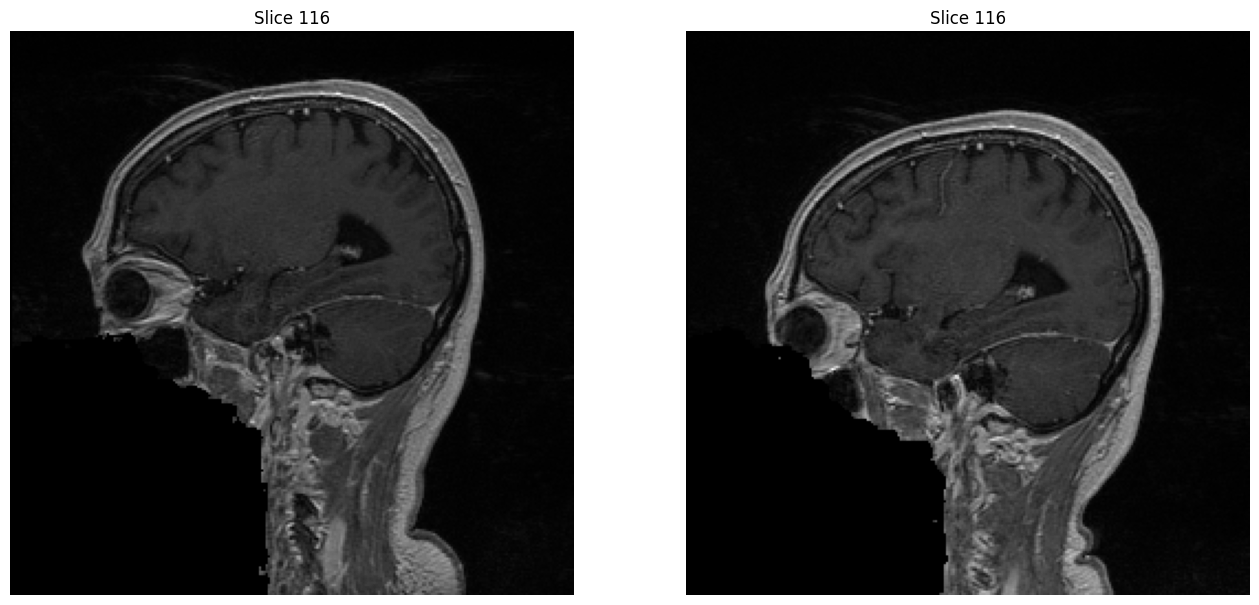

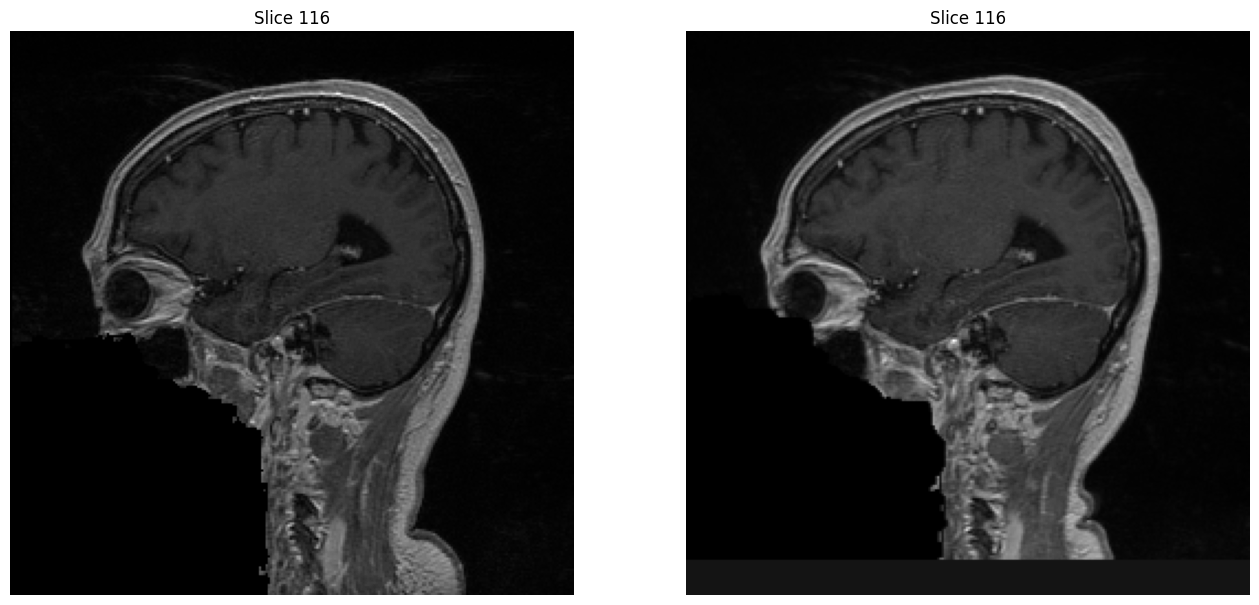

In [13]:
display_images(fixed_image, moving_image, 116)
display_images(fixed_image, registered_image_rigid, 116)

Dans l'ensemble, le processus d'enregistrement a aligné l'image mobile sur l'image fixe, ce qui a donné l'image enregistrée avec la même taille que les images d'origine.

---

### 2. Recalage affine

La fonction `register_images_affine` effectue l'enregistrement de deux images tridimensionnelles, `fixed_image` et `moving_image`, en utilisant une transformation affine. Voici comment la fonction est implémentée: 

In [14]:
def register_images_affine(fixed_image, moving_image):
    
    TransformType = itk.AffineTransform[itk.D, Dimension]
    OptimizerType = itk.RegularStepGradientDescentOptimizer
    MetricType = itk.MeanSquaresImageToImageMetric[FixedImageType, MovingImageType]
    InterpolatorType = itk.LinearInterpolateImageFunction[FixedImageType, itk.D]
    RegistrationType = itk.ImageRegistrationMethod[FixedImageType, MovingImageType]

    metric = MetricType.New()
    optimizer = OptimizerType.New()
    interpolator = InterpolatorType.New()
    registration = RegistrationType.New()
    transform = TransformType.New()

    registration.SetMetric(metric)
    registration.SetOptimizer(optimizer)
    registration.SetInterpolator(interpolator)
    registration.SetTransform(transform)

    registration.SetFixedImage(fixed_image)
    registration.SetMovingImage(moving_image)
    registration.SetFixedImageRegion(fixed_image.GetBufferedRegion())

    registration.SetInitialTransformParameters(transform.GetParameters())

    translation_scale = 1.0 / 1000.0

    OptimizerScalesType = itk.OptimizerParameters[itk.D]
    optimizer_scales = OptimizerScalesType(transform.GetNumberOfParameters())

    optimizer_scales[0] = 1.0
    optimizer_scales[1] = 1.0
    optimizer_scales[2] = 1.0
    optimizer_scales[3] = 1.0
    optimizer_scales[4] = 1.0
    optimizer_scales[5] = 1.0
    optimizer_scales[6] = 1.0
    optimizer_scales[7] = 1.0
    optimizer_scales[8] = 1.0
    optimizer_scales[9] = translation_scale
    optimizer_scales[10] = translation_scale
    optimizer_scales[11] = translation_scale

    optimizer.SetScales(optimizer_scales)

    step_length = 1.0
    maxNumberOfIterations = 500

    optimizer.SetMaximumStepLength(step_length)
    optimizer.SetMinimumStepLength(0.001)
    optimizer.SetNumberOfIterations(maxNumberOfIterations)
    optimizer.MinimizeOn()

    try:
        registration.Update()
        print("Optimizer stop condition: " + str(registration.GetOptimizer().GetStopConditionDescription()))
    except Exception as err:
        print(err)
        return None
    
    finalParameters = registration.GetOutput().Get().GetParameters()
    maxNumberOfIterations = optimizer.GetCurrentIteration()
    bestValue = optimizer.GetValue()

    print("Result = ")
    print(" Iterations    = " + str(maxNumberOfIterations))
    print(" Metric value  = " + str(bestValue))

    finalTransform = TransformType.New()
    finalTransform.SetParameters(finalParameters)
    finalTransform.SetFixedParameters(transform.GetFixedParameters())

    registered_image = resample_image(fixed_image, moving_image, finalTransform)

    return registered_image

In [15]:
registered_image_affine = register_images_affine(fixed_image, moving_image)
print("Registered image size: " + str(registered_image_affine.GetLargestPossibleRegion().GetSize()))

Optimizer stop condition: RegularStepGradientDescentOptimizer: Step too small after 448 iterations. Current step (0.000976562) is less than minimum step (0.001).
Result = 
 Iterations    = 449
 Metric value  = 6671.612835684993
Registered image size: itkSize3 ([256, 256, 176])


À partir des résultats fournis par la fonction register_images_affine, on peut en déduire ce qui suit :

- La transformation affine a été capable de trouver une configuration qui minimise la différence quadratique moyenne entre l'image fixe et l'image mobile après la transformation. Cela suggère que la transformation affine est une bonne approximation pour aligner les deux images.

- Le nombre maximal d'itérations (500) n'a pas été atteint, ce qui indique que l'optimisation a convergé (449) avant cette limite.

- La valeur de la métrique obtenue à la convergence est de 6671.612835684993. Cette valeur représente la quantité de différence entre les intensités des voxels des images fixe et mobile après la transformation. Plus la valeur de la métrique est faible, plus l'alignement entre les images est considéré comme bon.

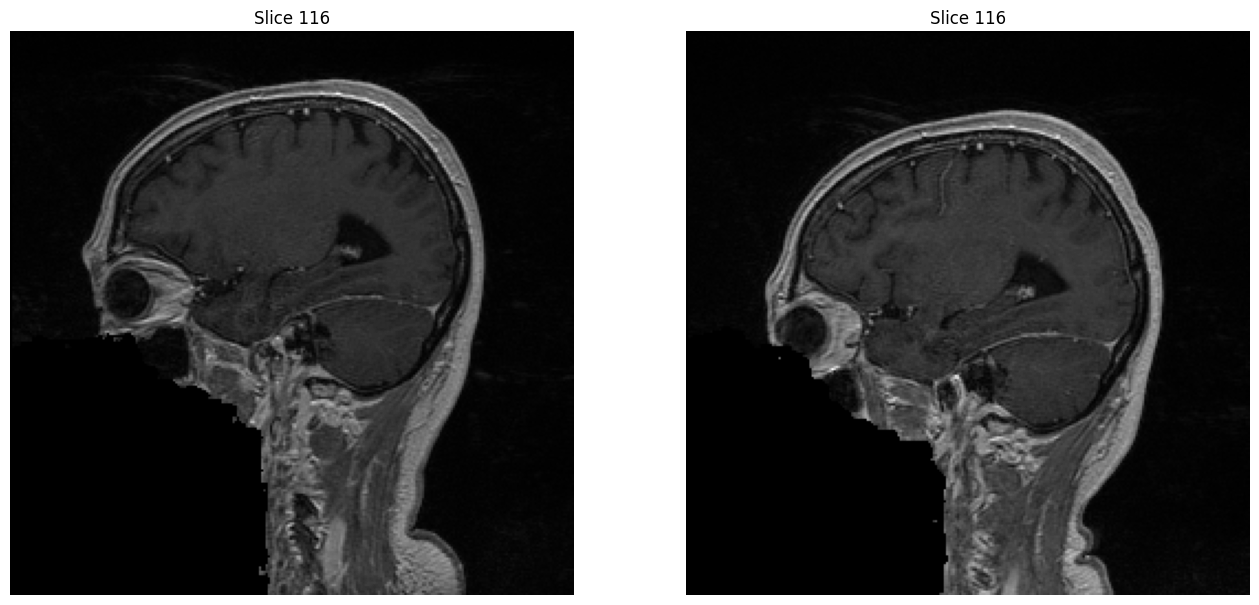

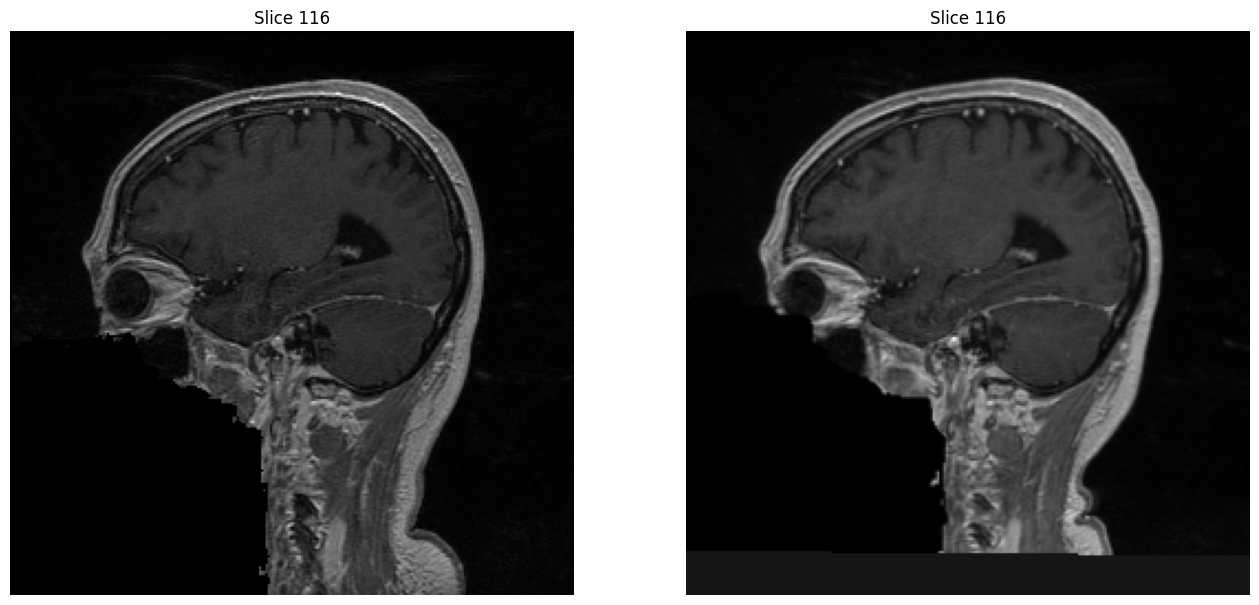

In [16]:
display_images(fixed_image, moving_image, 116)
display_images(fixed_image, registered_image_affine, 116)

Dans l'ensemble, le processus d'enregistrement a aligné l'image mobile sur l'image fixe, ce qui a donné l'image enregistrée avec la même taille que les images d'origine.

---

## Benchmark

### Différence des deux images

Voici une fonction qui calcule la différence entre deux images et renvoie la somme des valeurs de différence.

In [17]:
def calculate_total_difference(image1, image2):
    Dimension = image1.GetImageDimension()
    
    resampler = itk.ResampleImageFilter.New(Input=image2)
    resampler.SetReferenceImage(image1)
    resampler.UseReferenceImageOn()
    resampler.Update()

    PixelType = itk.F
    subtract_filter = itk.SubtractImageFilter[itk.Image[PixelType, Dimension], itk.Image[PixelType, Dimension], itk.Image[PixelType, Dimension]].New()
    subtract_filter.SetInput1(image1)
    subtract_filter.SetInput2(resampler.GetOutput())

    abs_diff_filter = itk.AbsImageFilter[itk.Image[PixelType, Dimension], itk.Image[PixelType, Dimension]].New()
    abs_diff_filter.SetInput(subtract_filter.GetOutput())
    abs_diff_filter.Update()

    statistics_filter = itk.StatisticsImageFilter[itk.Image[PixelType, Dimension]].New()
    statistics_filter.SetInput(abs_diff_filter.GetOutput())
    statistics_filter.Update()

    return statistics_filter

#### Recalage rigide

In [18]:
total_diff1 = calculate_total_difference(fixed_image, moving_image)
total_diff2 = calculate_total_difference(fixed_image, registered_image_rigid)
print("Total difference (fixed_image, moving_image):", total_diff1)
print("Total difference (fixed_image, registered_image_affine):", total_diff2)

Total difference (fixed_image, moving_image): StatisticsImageFilter (0x559ab31b4800)
  RTTI typeinfo:   itk::StatisticsImageFilter<itk::Image<float, 3u> >
  Reference Count: 1
  Modified Time: 175118
  Debug: Off
  Object Name: 
  Observers: 
    none
  Inputs: 
    Primary: (0x559ab4a0d330) *
  Indexed Inputs: 
    0: Primary (0x559ab4a0d330)
  Required Input Names: Primary
  NumberOfRequiredInputs: 1
  Outputs: 
    Maximum: (0x559ab41e2180)
    Mean: (0x559ab32fdf30)
    Minimum: (0x559ab3dbd540)
    Primary: (0)
    Sigma: (0x559ab42f46a0)
    Sum: (0x559ab3f96250)
    SumOfSquares: (0x559ab45823b0)
    Variance: (0x559ab4655830)
  Indexed Outputs: 
    0: Primary (0)
  NumberOfRequiredOutputs: 0
  Number Of Work Units: 256
  ReleaseDataFlag: Off
  ReleaseDataBeforeUpdateFlag: On
  AbortGenerateData: Off
  Progress: 1
  Multithreader: 
    RTTI typeinfo:   itk::TBBMultiThreader
    Reference Count: 1
    Modified Time: 175077
    Debug: Off
    Object Name: 
    Observers: 
      n

En analysant les résultats, voici les conclusions sur la méthode rigid3d :

- La différence totale entre les images initiales (fixed_image, moving_image) est évaluée à l'aide du filtre StatisticsImageFilter :
    - Count: 11534336
    - Minimum: 0
    - Maximum: 1734
    - Sum: 1.3808e+09
    - Mean: 119.712
    - Sigma: 185.442
    - Variance: 34388.7
    - SumOfSquares: 5.61949e+11
<br /> <br />
- La différence totale entre l'image fixe (fixed_image) et l'image enregistrée (registered_image_affine) est également évaluée à l'aide du filtre StatisticsImageFilter :
    - Count: 11534336
    - Minimum: 0
    - Maximum: 1368.44
    - Sum: 5.89978e+08
    - Mean: 51.1497
    - Sigma: 103.222
    - Variance: 10654.8
    - SumOfSquares: 1.53074e+11

Ces résultats indiquent que la méthode rigid3d a réussi à réduire la différence entre l'image fixe et l'image enregistrée par rapport à la différence initiale entre les images initiales. Cependant, il y a toujours une certaine différence résiduelle entre les deux images.

#### Recalage affine

In [19]:
total_diff1 = calculate_total_difference(fixed_image, moving_image)
total_diff2 = calculate_total_difference(fixed_image, registered_image_affine)
print("Total difference (fixed_image, moving_image):", total_diff1)
print("Total difference (fixed_image, registered_image_affine):", total_diff2)

Total difference (fixed_image, moving_image): StatisticsImageFilter (0x559ab3c474d0)
  RTTI typeinfo:   itk::StatisticsImageFilter<itk::Image<float, 3u> >
  Reference Count: 1
  Modified Time: 175435
  Debug: Off
  Object Name: 
  Observers: 
    none
  Inputs: 
    Primary: (0x559ab457b060) *
  Indexed Inputs: 
    0: Primary (0x559ab457b060)
  Required Input Names: Primary
  NumberOfRequiredInputs: 1
  Outputs: 
    Maximum: (0x559ab457b820)
    Mean: (0x559ab4bb92e0)
    Minimum: (0x559ab42391f0)
    Primary: (0)
    Sigma: (0x559ab35b3b50)
    Sum: (0x559ab3a39320)
    SumOfSquares: (0x559ab3ac3b00)
    Variance: (0x559ab39d77e0)
  Indexed Outputs: 
    0: Primary (0)
  NumberOfRequiredOutputs: 0
  Number Of Work Units: 256
  ReleaseDataFlag: Off
  ReleaseDataBeforeUpdateFlag: On
  AbortGenerateData: Off
  Progress: 1
  Multithreader: 
    RTTI typeinfo:   itk::TBBMultiThreader
    Reference Count: 1
    Modified Time: 175394
    Debug: Off
    Object Name: 
    Observers: 
      n

En analysant les résultats, voici les conclusions sur la méthode affine :

- La différence totale entre les images initiales (fixed_image, moving_image) est évaluée à l'aide du filtre StatisticsImageFilter :
    - Count: 11534336
    - Minimum: 0
    - Maximum: 1734
    - Sum: 1.3808e+09
    - Mean: 119.712
    - Sigma: 185.442
    - Variance: 34388.7
    - SumOfSquares: 5.61949e+11
<br /> <br />
- La différence totale entre l'image fixe (fixed_image) et l'image enregistrée avec la transformation affine (registered_image_affine) est également évaluée à l'aide du filtre StatisticsImageFilter :
    - Count: 11534336
    - Minimum: 0
    - Maximum: 1358
    - Sum: 5.41158e+08
    - Mean: 46.9171
    - Sigma: 95.2594
    - Variance: 9074.34
    - SumOfSquares: 1.30056e+11

Ces résultats indiquent que la méthode affine a réduit la différence entre l'image fixe et l'image enregistrée par rapport à la méthode rigid3d. La différence totale entre les deux images est plus faible avec la méthode affine, ce qui suggère que cette méthode est meilleure que la méthode rigid3d en termes de mesure de la différence entre les images.

---

### Différence de volume

In [24]:
def calculate_volume_difference(image1, image2):
    arr1 = itk.array_from_image(image1)
    arr2 = itk.array_from_image(image2)

    voxel_volume = image1.GetSpacing()[0] * image1.GetSpacing()[1] * image1.GetSpacing()[2]

    volume1 = (arr1 != 0).sum() * voxel_volume
    volume2 = (arr2 != 0).sum() * voxel_volume

    diff_volume = volume2 - volume1

    return volume1, volume2, diff_volume

In [25]:
volume1, volume2, diff_volume = calculate_volume_difference(fixed_image, moving_image)
print("Volume of fixed_image:", volume1)
print("Volume of moving_image:", volume2)
print("Difference in volume:", diff_volume)
print()
volume1, volume2, diff_volume = calculate_volume_difference(fixed_image, registered_image_rigid)
print("Volume of fixed_image:", volume1)
print("Volume of registered_image_rigid:", volume2)
print("Difference in volume:", diff_volume)

Volume of fixed_image: 9247595.0
Volume of moving_image: 9370890.0
Difference in volume: 123295.0

Volume of fixed_image: 9247595.0
Volume of registered_image_rigid: 9584398.0
Difference in volume: 336803.0


In [26]:
volume1, volume2, diff_volume = calculate_volume_difference(fixed_image, moving_image)
print("Volume of fixed_image:", volume1)
print("Volume of moving_image:", volume2)
print("Difference in volume:", diff_volume)
print()
volume1, volume2, diff_volume = calculate_volume_difference(fixed_image, registered_image_affine)
print("Volume of fixed_image:", volume1)
print("Volume of registered_image_affine:", volume2)
print("Difference in volume:", diff_volume)

Volume of fixed_image: 9247595.0
Volume of moving_image: 9370890.0
Difference in volume: 123295.0

Volume of fixed_image: 9247595.0
Volume of registered_image_affine: 9626638.0
Difference in volume: 379043.0


Il est logique que la différence de volume entre l'image fixe et l'image enregistrée soit plus grande que celle entre l'image fixe et l'image mobile. L'enregistrement affine ou rigide peut entraîner des déformations plus importantes de l'image mobile par rapport à l'image fixe, ce qui peut entraîner une différence de volume plus importante. La différence de volume est une mesure de l'étendue des changements entre les deux images, et ces changements peuvent être plus prononcés dans le cas de l'enregistrement affine par rapport à l'enregistrement rigide ou par rapport à l'image mobile d'origine.

Cela indique que l'enregistrement affine a introduit des transformations plus significatives dans l'image mobile par rapport à l'image fixe. La différence de volume plus grande entre l'image fixe et l'image enregistrée affine suggère que des changements structurels plus importants ont été appliqués à l'image mobile lors de l'enregistrement.

## Sauvegarde des données

In [27]:
def write_file(image, file_path):
    writerType = itk.ImageFileWriter[ImageType]
    writer = writerType.New()
    writer.SetFileName(file_path)
    writer.SetInput(image)
    writer.Update()